In [1]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import numpy
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
# import

In [20]:
train_data = pd.read_csv('..//raw_data//train.csv')
test_data = pd.read_csv('..//raw_data//test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Imputing
&ensp; Fortunately, we have only 2 columns that have missing values with significant frequency, those being Cabin(cabin number)  and Age.
Fare and Embarked also have missing values but they are few, the train set only missing 2 Embarked values and full Fare information, and the test set missing only 1 Fare value.
With Embarked, the situation is simple because the main majority of people that got on, did so at Southampton and there are only 2 missing values, so just attributing "S" to them should be sufficient.

The problem is that "Cabin" has only around 1/4 of the values not missing, even though it could have been an useful piece of information. It would be better to just drop it because the number of values we actually have is very small.

For Age, since it is a numerical column, numerous approaches may be adopted and each may have its advantages(median, mean or inferring it from other columns). Because mean fits quite nicely with the age distribution (as we see below, the red line being the mean), we will use it.

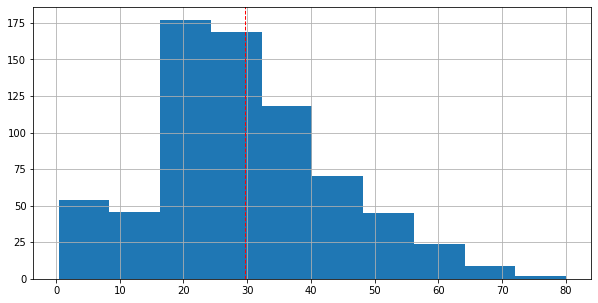

In [5]:
fig, ax = plt.subplots(figsize = (10,5))
train_data.Age.hist(ax =ax , label = "train")
ax.axvline(x=train_data.Age.mean(),ymin= 0, ymax = 180, color='r', linestyle='dashed', linewidth=1)

In [6]:
print("Train: ",train_data.Cabin.isna().sum(), "missing out of ", len(train_data), "(%f)percent"%(train_data.Cabin.isna().sum() / len(train_data) * 100)) 
print("Test: ",test_data.Cabin.isna().sum(), "missing out of ", len(test_data), "(%f)percent"%(test_data.Cabin.isna().sum() / len(test_data) * 100))


Train:  687 missing out of  891 (77.104377)percent
Test:  327 missing out of  418 (78.229665)percent


In [7]:
print(train_data.Embarked.isna().sum())
train_data.groupby("Embarked").count()

2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
Embarked,,,,,,,,,,,
C,168,168,168,168,168,130,168,168,168,168,69
Q,77,77,77,77,77,28,77,77,77,77,4
S,644,644,644,644,644,554,644,644,644,644,129


In [14]:
def imputing(train_data, method='mean', age_value = None):
    train = train_data.copy()
    train.Embarked.fillna("S",inplace = True)
    train.Fare.fillna(train.Fare.mean(),inplace = True)
    
    train.drop("Cabin", axis = 1, inplace = True)
    
    if method == 'mean':
        train.Age.fillna(train.Age.mean(), inplace = True)
    if method == 'median':
        train.Age.fillna(train.Age.median(), inplace = True)
    if age_value is not None:
        train.Age.fillna(age_value, inplace = True)
    
    train['Alone'] = 0 + (train.SibSp + train.Parch > 0)
    return train

In [21]:
train_data = base_preprocessing(train_data)
test_data = base_preprocessing(test_data, age_value = train_data.Age.mean())

Check the inputing was done correctly

In [22]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Alone        891 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 80.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1 

In [23]:
def split_train(train_data,ratio = 0.2):
    train_y = train_data.Survived
    train_data.drop("Survived",axis = 1,inplace = True)
    return model_selection.train_test_split(train_data,
                                                        train_y,
                                                        test_size=ratio)

In [24]:
X_train, X_test, y_train, y_test = split_train(train_data)

In [25]:
# !jupyter nbconvert --to script imputing.ipynb

In [26]:
ordinal = OrdinalEncoder()
onehot = OneHotEncoder()

# Important note:
While i tried using the Transformers provided in sklearn, they reordered the columns in a way that made the dataset unmanageable afterwards, and some later visualisations and deductions rely on the fact that we know which are the columns.
<br>
This is by far the biggest inconvenience until now, but the amount of work needed to work around it is far greater than the work needed to develop a solution for both encodings used. 
<br>
Here we drop the columns which are not useful in making predictions as they offer no real information(Ticked ID and Passenger ID) as to they may provide the boosted trees an opportunity to overfit and transform the categorical ones (Sex and Embarked) into their encodings. Also, we exctract knowledge from the Name column in the form of Title, which may provide additional infomation in regard to the social status of the person.

In [49]:
def name_to_title(name):
    return name.split(',')[1].split('.')[0].strip()
titles_train = set([name_to_title(name) for name in train_data['Name']])
titles_test = set([name_to_title(name) for name in test_data['Name']])
titles = titles_train | titles_test # set union
titles

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

We create a dictionary for standardinze different terms to a common meaning (eg. Captain and Colonel to Officer)

In [53]:
title_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona":"Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
def transform_titles(dataset):
    dataset['Title'] = dataset['Name'].map(lambda name:name_to_title(name))
    dataset['Title'] = dataset['Title'].map(lambda title:title_dict[title])
transform_titles(test_data)
test_data.head()
# pd.get_dummies(test_data['Embarked'],prefix = 'Embarked')

,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1
...,...,...,...
413,0,0,1
414,1,0,0
415,0,0,1
416,0,0,1


In [76]:
def transform(dataset, encoder):
    transformed_dataset = dataset.copy()
    transformed_dataset['Title'] = transformed_dataset['Name'].map(lambda name:name_to_title(name))
    transformed_dataset['Title'] = transformed_dataset['Title'].map(lambda title:title_dict[title])
    transformed_dataset.drop("Name",axis =1, inplace = True)
    transformed_dataset.drop("PassengerId", axis =1, inplace = True)
    transformed_dataset.drop("Ticket",axis =1, inplace = True)
    if type(encoder) is OrdinalEncoder:
        transformed_dataset.Sex = encoder.fit_transform(transformed_dataset.Sex.values.reshape(-1,1))
        transformed_dataset.Embarked = encoder.fit_transform(transformed_dataset.Embarked.values.reshape(-1,1))
        transformed_dataset.Title = encoder.fit_transform(transformed_dataset.Title.values.reshape(-1,1))
    if type(encoder) is OneHotEncoder:
        sex_dummies = pd.get_dummies(transformed_dataset['Sex'], prefix = 'Sex')
        embarked_dummies = pd.get_dummies(transformed_dataset['Embarked'], prefix = 'Embarked')
        title_dummies = pd.get_dummies(transformed_dataset['Title'], prefix = 'Title')
        transformed_dataset = pd.concat([transformed_dataset,embarked_dummies,sex_dummies,title_dummies], axis = 1)
#         transformed_dataset["Sex1"] = sex_encoded[:,0]
#         transformed_dataset["Sex2"] = sex_encoded[:,1]
#         transformed_dataset["Embarked1"] = embark_encoded[:,0]
#         transformed_dataset["Embarked2"] = embark_encoded[:,1]
#         transformed_dataset["Embarked3"] = embark_encoded[:,2]
        transformed_dataset.drop("Sex",axis = 1, inplace = True)
        transformed_dataset.drop("Embarked", axis = 1, inplace =  True)
        transformed_dataset.drop("Title",axis =1, inplace = True)
    return transformed_dataset

In [77]:
transformed_train = transform(X_train,onehot)
transformed_test = transform(X_test,onehot)

In [78]:
transformed_train.head()

,Pclass,Age,SibSp,Parch,Fare,Alone,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
781,1,17.000000,1,0,57.0000,1,0,0,1,1,0,0,0,0,1,0,0
464,3,29.699118,0,0,8.0500,0,0,0,1,0,1,0,0,1,0,0,0
419,3,10.000000,0,2,24.1500,1,0,0,1,1,0,0,1,0,0,0,0
435,1,14.000000,1,2,120.0000,1,0,0,1,1,0,0,1,0,0,0,0
844,3,17.000000,0,0,8.6625,0,0,0,1,0,1,0,0,1,0,0,0


## Standardizing
Many algorithms benefit from having mean 0 and variance 1, especially for continuous variables.
<br>
Since we use PCA, this method is preferred to others such as min/max normalization
<br>
Also, the test set should be normalized by the train set's mean and std.

In [79]:
def standardize(dataset, means = None , stds = None ,columns = ["Age","Fare"]):
    """If means is null, it will standardize using the dataframe's values.
    If the means is given, it will use these and the std's provided."""
    standardized_dataset = dataset.copy()
    for i,column_name in enumerate(columns):
        column = standardized_dataset[column_name]
        if means is None:
            mean = column.mean()
            std = column.std()
        else:
            mean = means[i]
            std = stds[i]
        standardized_dataset[column_name] = (column - mean) / std
    return standardized_dataset

In [80]:
means = [transformed_train.Age.mean(),transformed_train.Fare.mean()]
stds = [transformed_train.Age.std(), transformed_train.Fare.std()]
standardized_train = standardize(transformed_train)
standardized_test=  standardize(transformed_test, means,stds)


Double checking that the standardization was done correctly:
The test mean is not 0 due to the train-test mismatch

In [81]:
standardized_test.Age.mean()

-0.07653960746722578

In [82]:
standardized_train.Age.mean()

4.166454946346093e-16

# Save all the steps

In [90]:
raw_train = pd.read_csv('..//raw_data//train.csv')
raw_test = pd.read_csv('..//raw_data//test.csv')

imputed_train = base_preprocessing(raw_train)
imputed_test = base_preprocessing(raw_test, age_value = raw_train.Age.mean())


imputed_train.to_csv("..//processed_data//imputed_train.csv",index = False)
imputed_test.to_csv("..//processed_data//imputed_test.csv",index = False)

In [91]:
ordinal = OrdinalEncoder()
onehot = OneHotEncoder()

ordinal_train = transform(imputed_train,ordinal)
onehot_train = transform(imputed_train,onehot)

ordinal_test = transform(imputed_test,ordinal)
onehot_test = transform(imputed_test,onehot)


ordinal_train.to_csv("..//processed_data//transformed_train_ordinal.csv",index = False)
onehot_train.to_csv("..//processed_data//transformed_train_onehot.csv",index = False)

ordinal_train.to_csv("..//processed_data//transformed_test_ordinal.csv",index = False)
onehot_test.to_csv("..//processed_data//transformed_test_onehot.csv",index = False)

In [92]:
means = [ordinal_train.Age.mean(),ordinal_train.Fare.mean()]
stds = [ordinal_train.Age.std(), ordinal_train.Fare.std()]
standardized_train_ordinal = standardize(ordinal_train)
standardized_test_ordinal=  standardize(ordinal_test, means,stds)

standardized_train_ordinal.to_csv("..//processed_data//standardized_train_ordinal.csv",index = False)
standardized_test_ordinal.to_csv("..//processed_data//standardized_test_ordinal.csv",index = False)


means = [onehot_train.Age.mean(),onehot_train.Fare.mean()]
stds = [onehot_train.Age.std(), onehot_train.Fare.std()]
standardized_train_onehot = standardize(onehot_train)
standardized_test_onehot=  standardize(onehot_test, means,stds)

standardized_train_onehot.to_csv("..//processed_data//standardized_train_onehot.csv",index = False)
standardized_test_onehot.to_csv("..//processed_data//standardized_test_onehot.csv",index = False)